In [ ]:
import json
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from tqdm.notebook import tqdm, trange
from time import perf_counter
from PIL import Image
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import numpy as np
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)
    
seed_val = 24
set_seed(seed_val)

In [ ]:
IMAGE_FOLDER = "C:/Users/jayan/Downloads/MMHS150K/img_resized/"
TEXT_FOLDER = "C:/Users/jayan/Downloads/MMHS150K/img_txt/"
annotations = "C:/Users/jayan/Downloads/MMHS150K/MMHS150K_GT.json"

In [ ]:
import json
 
# Opening JSON file
with open(annotations) as json_file:
    data = json.load(json_file)
    
data_df1 = pd.DataFrame(data).T.reset_index()
data_df1.rename(columns = {'index':'id'}, inplace = True)

In [ ]:
combined_names_mapping = {
    0: 'Not Hate Speech',
    1: 'Identity-Based',
    2: 'Gender and Sexual Orientation-Based',
    5: 'Other forms of Hate Speech'
}

# Function to combine classes
def combine_classes(original_class):
    if original_class in [1, 4]:  # Combine classes 1 and 4 into 1
        return 1
    elif original_class in [2, 3]:  # Combine classes 2 and 3 into 2
        return 2
    else:
        return original_class  # Keep classes 0 and 5 unchanged

# Apply the combination of classes to each item in the dataset and create a new column 'combined_names_str'
for tweet_id, tweet_data in data.items():
    original_classes = tweet_data['labels']
    combined_classes = [combine_classes(cls) for cls in original_classes]
    tweet_data['combined_labels'] = combined_classes
    tweet_data['combined_names_str'] = combined_names_mapping.get(combined_classes[0], 'Unknown')

In [ ]:
import pandas as pd
data_df1 = pd.DataFrame(data).T.reset_index()
data_df1.rename(columns = {'index':'id'}, inplace = True)

In [ ]:
train_df = pd.read_csv("C:/Users/jayan/Downloads/MMHS150K/splits/train_ids.txt", header=None)
train_df.columns = ['id']
valid_df = pd.read_csv("C:/Users/jayan/Downloads/MMHS150K/splits/val_ids.txt", header=None)
valid_df.columns = ['id']
test_df = pd.read_csv("C:/Users/jayan/Downloads/MMHS150K/splits/test_ids.txt", header=None)
test_df.columns = ['id']

train_df['image_path'] = IMAGE_FOLDER + train_df['id'].astype(str) + '.jpg'
valid_df['image_path'] = IMAGE_FOLDER + valid_df['id'].astype(str) + '.jpg'
test_df['image_path'] = IMAGE_FOLDER + test_df['id'].astype(str) + '.jpg'

In [ ]:
train_df['text_path'] = TEXT_FOLDER + train_df['id'].astype(str) + '.json'
valid_df['text_path'] = TEXT_FOLDER + valid_df['id'].astype(str) + '.json'
test_df['text_path'] = TEXT_FOLDER + test_df['id'].astype(str) + '.json'

In [ ]:
train_df['id'] = train_df['id'].astype(str)
test_df['id'] = test_df['id'].astype(str)
valid_df['id'] = valid_df['id'].astype(str)

In [ ]:
data_df1['id'] = data_df1['id'].astype(str)

train_df = train_df.merge(data_df1, on='id', how='left')
valid_df = valid_df.merge(data_df1, on='id', how='left')
test_df = test_df.merge(data_df1, on='id', how='left')

In [ ]:
train_df['text_path1'] = train_df['text_path'].str.split('/').apply(lambda a:a[-1])
test_df['text_path1'] = test_df['text_path'].str.split('/').apply(lambda a:a[-1])

In [ ]:
# Remove 'img_txt' prefix from filenames in 'text_path1' column
train_df['text_path1'] = train_df['text_path1'].str.replace('img_txt', '')
test_df['text_path1'] = test_df['text_path1'].str.replace('img_txt', '')

In [ ]:
files_in_directory = os.listdir("C:/Users/jayan/Downloads/MMHS150K/img_txt/")
train_df['text_available'] = train_df['text_path1'].apply(lambda x: x in files_in_directory)

In [ ]:
test_df['text_path1'] = test_df['text_path1'].str.replace('img_txt', '')
test_df['text_available'] = test_df['text_path1'].isin(os.listdir("C:/Users/jayan/Downloads/MMHS150K/img_txt"))
test_df['text_available'].head()
train_df = train_df[train_df.text_available == True]
test_df = test_df[test_df.text_available == True]


In [ ]:
train_df['image_path1'] = train_df['image_path'].str.split('/').apply(lambda a:a[-1])
test_df['image_path1'] = test_df['image_path'].str.split('/').apply(lambda a:a[-1])

train_df['image_available'] = train_df['image_path1'].isin(os.listdir("C:/Users/jayan/Downloads/MMHS150K/img_resized"))
test_df['image_available'] = test_df['image_path1'].isin(os.listdir("C:/Users/jayan/Downloads/MMHS150K/img_resized"))
train_df = train_df[train_df.text_available == True]
test_df = test_df[test_df.text_available == True]

In [ ]:
with open('C:/Users/jayan/Downloads/MMHS150K/img_txt/1023940826882293760.json') as json_file:
    data = json.load(json_file)
text = data['img_text']
print(text)


import matplotlib.pyplot as plt

def show_text(path):
    try:
        with open(path) as json_file:
            data = json.load(json_file)
        text = data['img_text']
    except FileNotFoundError:
        text = "File not found."
    return text



def show_sample(row_num):
    sample_row = train_df.iloc[row_num]
    print('Index:', row_num)
    print('Label:', sample_row['combined_names_str'])
    print('Label:', sample_row['combined_labels'])
    print('Text:', show_text(sample_row['text_path']))
    image_path = sample_row['image_path']
    im = Image.open(image_path)
    plt.imshow(im)
    
from random import randint
show_sample(randint(0, len(train_df)))

In [ ]:
train_df['label1'] = train_df['combined_labels'].apply(lambda a: a[0])

test_df['label1'] = test_df['combined_labels'].apply(lambda a: a[0])

train_df['label1'].unique()

train_df['text'] = train_df.apply(lambda x: show_text(x['text_path']), axis=1)
train_df['text']

class TextDataset(Dataset):
    def __init__(self, df, text="text", label_field="label1"):
        self.df = df.reset_index(drop=True)
        self.text = text
        self.label_field = label_field
                          
    def __getitem__(self, index):
        text = self.df.at[index, self.text]
        label = self.df.at[index, self.label_field]
        
        return text, label

    def __len__(self):
        return self.df.shape[0]
    
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


In [ ]:
class VLBertModel(nn.Module):

    def __init__(self, num_labels, text_pretrained='bert-base-uncased'):
        super().__init__()

        self.num_labels = num_labels
        self.text_encoder = AutoModel.from_pretrained(text_pretrained)
        self.classifier = nn.Linear(
            self.text_encoder.config.hidden_size, num_labels)
        
    
    def forward(self, text):
        output = self.text_encoder(text.input_ids, attention_mask=text.attention_mask, return_dict=True)
        logits = self.classifier(output.last_hidden_state[:, 0, :]) # CLS embedding
        return logits
    
num_out_labels = 6
num_train_epochs = 10
batch_size = 16
learning_rate = 1.0e-4
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

bert_model = VLBertModel(num_labels=num_out_labels, text_pretrained='bert-base-uncased')
bert_model = bert_model.to(device)

set_seed(seed_val)

In [ ]:
#custom dataset created from above
train_dataset = TextDataset(df=train_df, text='tweet_text', label_field='label1')
train_sampler = RandomSampler(train_dataset)        
train_dataloader = DataLoader(dataset=train_dataset,
                    batch_size=batch_size, 
                    sampler=train_sampler)


t_total = len(train_dataloader) * num_train_epochs

In [ ]:
#optimizer
optimizer = AdamW(bert_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#learning rate scheduler
scheduler = get_scheduler(name="cosine", optimizer=optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total)

#loss function
criterion = nn.CrossEntropyLoss()

bert_model.train()

#tell you starting time
start = perf_counter()
#trange gives u a progress bar where 'desc' is the label for ur progress bar
for epoch_num in trange(num_train_epochs, desc='Epochs'):
    epoch_total_loss = 0
  #tqdm also another progress bar
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='Batch'):        
        b_text, b_labels = batch            
        b_inputs = bert_tokenizer(
            list(b_text), truncation=True, max_length=max_seq_length,
            return_tensors="pt", padding=True
            )
        
        b_labels = b_labels.to(device)
        b_inputs = b_inputs.to(device)

        bert_model.zero_grad()        
        b_logits = bert_model(text=b_inputs)
        
        loss = criterion(b_logits, b_labels)

        epoch_total_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()


        optimizer.step()
        scheduler.step()
    
    avg_loss = epoch_total_loss/len(train_dataloader)


    print('epoch =', epoch_num)
    print('    epoch_loss =', epoch_total_loss)
    print('    avg_epoch_loss =', avg_loss)
    print('    learning rate =', optimizer.param_groups[0]["lr"])

end = perf_counter()
bert_training_time = end- start
print('Training completed in ', bert_training_time, 'seconds')


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Convert bert_prediction_probs to a NumPy array if it's not already
bert_prediction_probs = np.array(bert_prediction_probs)

# Binarize the labels for multi-class
n_classes = len(np.unique(test_df['label1']))
y_true = label_binarize(test_df['label1'], classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], bert_prediction_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

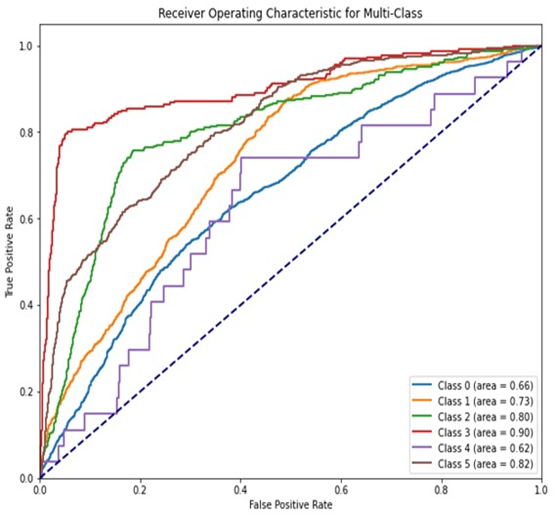

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Specify the actual classes you have
actual_classes = [0, 1, 2, 5]
n_classes = len(actual_classes)

# Binarize the labels
y_true = label_binarize(test_df['label1'], classes=actual_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, class_label in enumerate(actual_classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_true[:, i], bert_prediction_probs[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot all ROC curves
plt.figure(figsize=(8, 6))

# Define a color for each class
colors = {0: 'aqua', 1: 'darkorange', 2: 'cornflowerblue', 5: 'green'}

for class_label in actual_classes:
    plt.plot(fpr[class_label], tpr[class_label], color=colors[class_label], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_label, roc_auc[class_label]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

 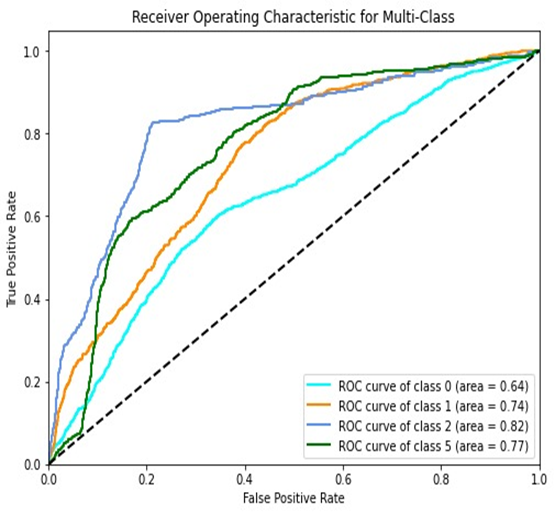

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_df['label1'] contains actual labels and bert_prediction_labels contains predicted labels

# Generate a raw confusion matrix
conf_matrix = confusion_matrix(test_df['label1'], bert_prediction_labels)

# Normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3], cbar=False)

plt.title('Normalized Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


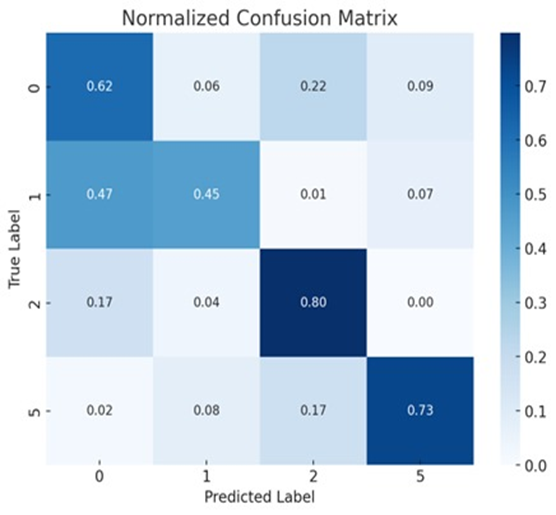